# Time Series Learning
Link: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
      <br>        https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/
      <br>https://machinelearningmastery.com/time-series-data-stationary-python/
      <br>https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/
      <br>http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/

**Objective**: learning basic <font color='red'>**Time Series concepts and codes**</font> in Python

***Time Series Data***:
1. Constant time intervals
2. Time dependent: y and ti are dependent
3. difference and seasonality trends

***Data used***:
'AirPassengers' 

In [34]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
%matplotlib inline
rcParams['figure.figsize']=15, 6

## Import and Explore Data

In [35]:
data=pd.read_csv('AirPassengers.csv')

In [36]:
print(len(data), 'records.\n')
print('Time Frame: from ',data.Month.min(),' to ', data.Month.max() )
data.head()

144 records.

Time Frame: from  1949-01  to  1960-12


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [37]:
print('Basic exploration on "#Paasengers":')
data.describe()

Basic exploration on "#Paasengers":


,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [38]:
print('check data type in table:')
data.dtypes

check data type in table:


Month          object
#Passengers     int64
dtype: object

In [39]:
print('"Month" data type:',type(data.Month[1]))

"Month" data type: <class 'str'>


Convert "Month" columns to datetime.

In [40]:
data['Time']=pd.to_datetime(data.Month)

In [41]:
print('check data type in table:')
print(data.dtypes)
data.head()

check data type in table:
Month                  object
#Passengers             int64
Time           datetime64[ns]
dtype: object


,Month,#Passengers,Time
0,1949-01,112,1949-01-01
1,1949-02,118,1949-02-01
2,1949-03,132,1949-03-01
3,1949-04,129,1949-04-01
4,1949-05,121,1949-05-01


Or we can set arguments in read_csv to parse data type

In [42]:
data=pd.read_csv('AirPassengers.csv',parse_dates=['Month'])

In [43]:
print('check data type in table:')
print(data.dtypes)

check data type in table:
Month          datetime64[ns]
#Passengers             int64
dtype: object


In [44]:
data.loc[(data.Month>'1949-05')&(data.Month<'1950-04')] # subset dataset by time

,Month,#Passengers
5,1949-06-01,135
6,1949-07-01,148
7,1949-08-01,148
8,1949-09-01,136
9,1949-10-01,119
10,1949-11-01,104
11,1949-12-01,118
12,1950-01-01,115
13,1950-02-01,126
14,1950-03-01,141


## Check Stationarity of Time Series

Statistical properties remain constant over time.
    - Mean, Variance, autocovariance not depending on time.

**Method 1 Plotting**

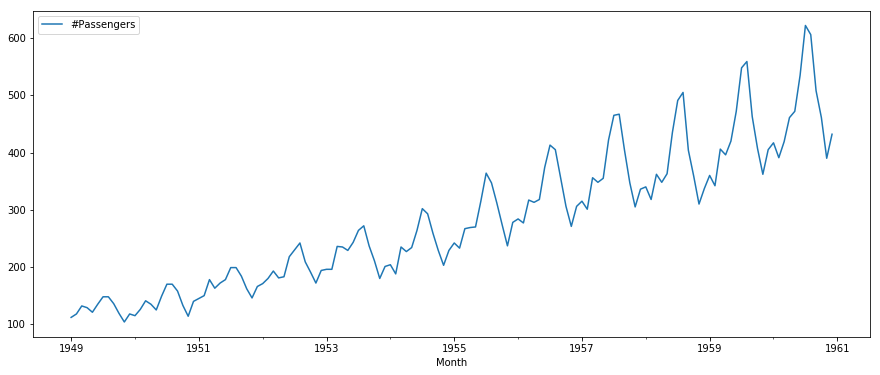

In [45]:
data.plot(x='Month',y='#Passengers') 

Intepretation: Trend + seasonality

**Method 2 Plotting Rolling Stastics**

In [46]:
def RollingPlot(data,rolling_cols=[],window=5):
    for col in rolling_cols:
        print(col,':\n')
        data['rolling_'+col+'_mean']=data[col].rolling(window=window).mean()
        data['rolling_'+col+'_std']=data[col].rolling(window=window).std()
        data.plot(x='Month',y=[col,'rolling_'+col+'_mean','rolling_'+col+'_std'])
        data=data.drop(['rolling_'+col+'_mean','rolling_'+col+'_std'],axis=1)
    return data

#Passengers :



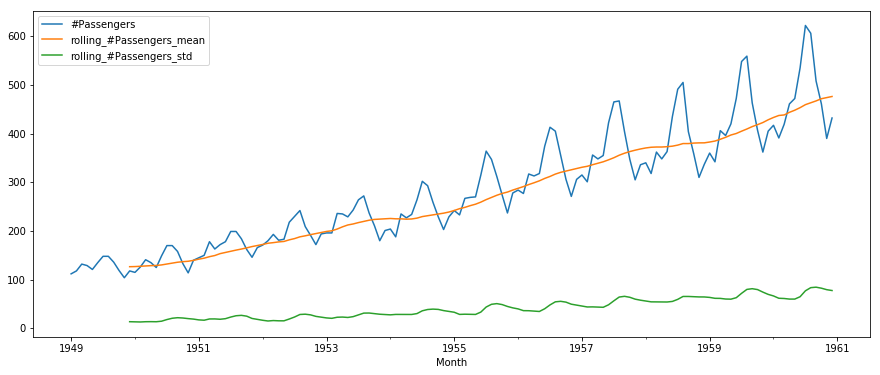

In [47]:
data=RollingPlot(data,['#Passengers'],12)

**Dickey-Fuller Test**
<br>***Null Hypothesis (H0)***: If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
<BR>***Alternate Hypothesis (H1)***: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

In [48]:
DF_test=adfuller(data['#Passengers'],regression='c')
print('P-value for Dickey_Fuller Test:',DF_test[1])

P-value for Dickey_Fuller Test: 0.9918802434376409


In [49]:
DF_test=adfuller(data['#Passengers'],regression='ct')
print('P-value for Dickey_Fuller Test when considering trend:',DF_test[1])

P-value for Dickey_Fuller Test when considering trend: 0.5456589343124538


In [50]:
DF_test=adfuller(data['#Passengers'],regression='ctt')
print('P-value for Dickey_Fuller Test when considering linear and quadratic trend:',DF_test[1])

P-value for Dickey_Fuller Test when considering linear and quadratic trend: 0.19594187397034846


## Transform Time Series to Stationary TS
1. Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
2. Seasonality – variations at specific time-frames.
<br>***Methods***:
<br>(1). Aggregation – taking average for a time period like monthly/weekly averages
<br>(2). Smoothing – taking rolling averages
<br>(3). Polynomial Fitting – fit a regression model
<br>(4). Transforamtion - log, square root, cube root, etc.

**Method 1 (Step 1) Transformation**

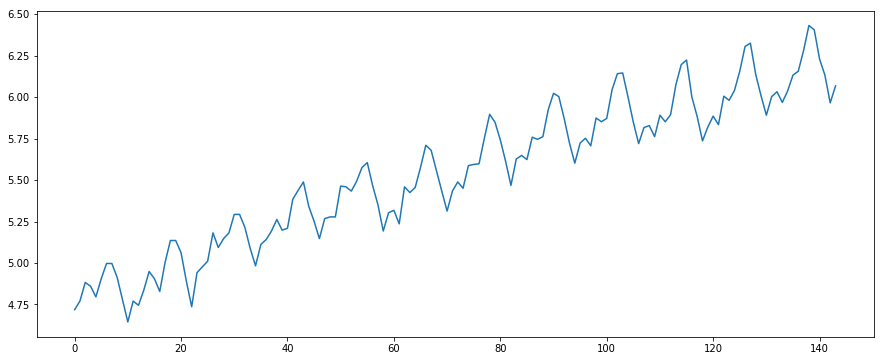

In [51]:
ts_log=np.log(data['#Passengers'])
ts_log.plot()

**Method 2 (Step 2) Moving Average**
<br>X(t)-MA(t)

log_ma_diff :

P-value for Dickey_Fuller Test: 0.022234630001244364


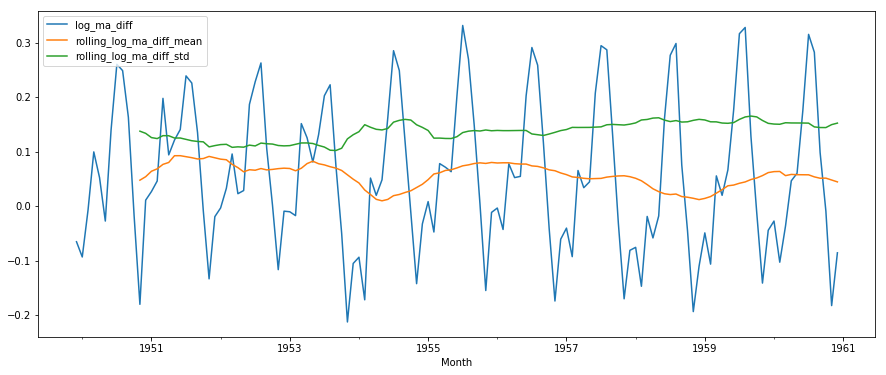

In [52]:
data_lma=data.copy()
ts_log_moving_avg_diff=ts_log-ts_log.rolling(12).mean()
data_lma['log_ma_diff']=ts_log_moving_avg_diff
data_lma=data_lma.dropna() # remove first 12

# Plot
data_lma=RollingPlot(data_lma,rolling_cols=['log_ma_diff'],window=12)
# Dickey-Fuller Test
DF_test=adfuller(data_lma['log_ma_diff'],regression='c')
print('P-value for Dickey_Fuller Test:',DF_test[1])

**Method 3 (Step 2) Weighted Moving Average**
<br>a drawback in this particular approach is that the time-period has to be strictly defined. In this case we can take yearly averages but in complex situations like forecasting a stock price, its difficult to come up with a number. 
<br>we take a ***‘weighted moving average’*** where more recent values are given a higher weight. There can be many technique for assigning weights. A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor. 

log_wma_diff :

P-value for Dickey_Fuller Test: 0.0057369388015122555


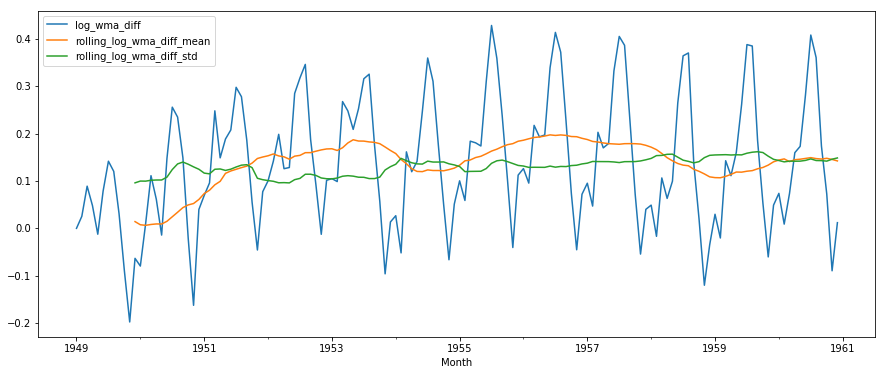

In [53]:
data_lwma=data.copy()
ts_log_weighted_moving_avg_diff=ts_log-ts_log.ewm(halflife=12).mean()
data_lwma['log_wma_diff']=ts_log_weighted_moving_avg_diff
data_lwma=data_lwma.dropna() # remove first 11

# Plot
data_lwma=RollingPlot(data_lwma,rolling_cols=['log_wma_diff'],window=12)
# Dickey-Fuller Test
DF_test=adfuller(data_lwma['log_wma_diff'],regression='c')
print('P-value for Dickey_Fuller Test:',DF_test[1])

## Eliminating Trend and Seasonality
1. Differencing : X(ti)-X(tj)
2. Decomposition: modeling both trend and seasonality and removing them from model

**Method 1 Differencing**

log_diff :

P-value for Dickey_Fuller Test: 0.07112054815086118


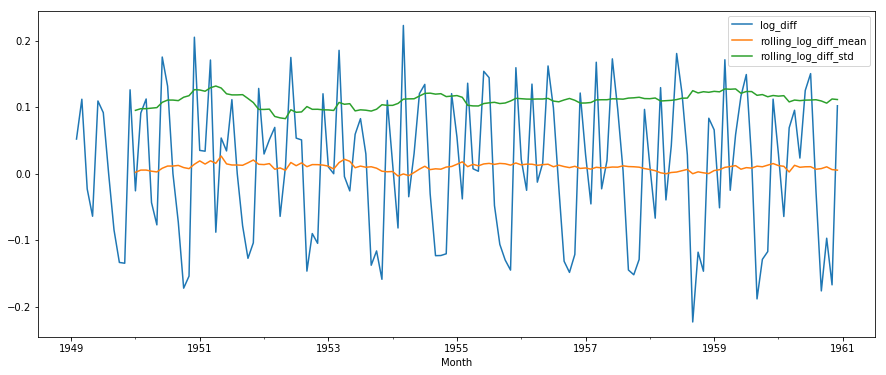

In [54]:
data_df=data.copy()
data_df['log_diff']=ts_log-ts_log.shift(periods=1) # find best differncing peirod
data_df=data_df.dropna()

# Plot
data_df=RollingPlot(data_df,rolling_cols=['log_diff'],window=12)
# Dickey-Fuller Test
DF_test=adfuller(data_df['log_diff'],regression='c')
print('P-value for Dickey_Fuller Test:',DF_test[1])

**Method 2 Decomposing**
<br> Seperate seasonality and trend from data by modeling, only residual will be used as data to model
<br> Link: https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

In [60]:
ts_log_time=ts_log.copy()
ts_log_time.index=data.Month
decom=seasonal_decompose(ts_log_time,model='additive') # it must be a series with time as index.

In [61]:
trend=decom.trend
seasonal=decom.seasonal
residual=decom.resid

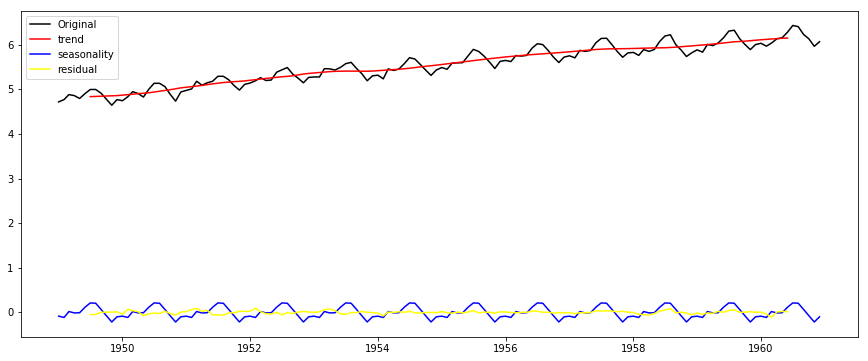

In [62]:
plt.plot(ts_log_time,label='Original',color='black')
#plt.legend(loc='best')
plt.plot(trend,label='trend',color='red')
#plt.legend(loc='best')
plt.plot(seasonal,label='seasonality',color='blue')
#plt.legend(loc='best')
plt.plot(residual,label='residual',color='yellow')
plt.legend(loc='best')
plt.show()

**Combined bother methods**
1. Make difference 
2. decompose
3. remove seasonality

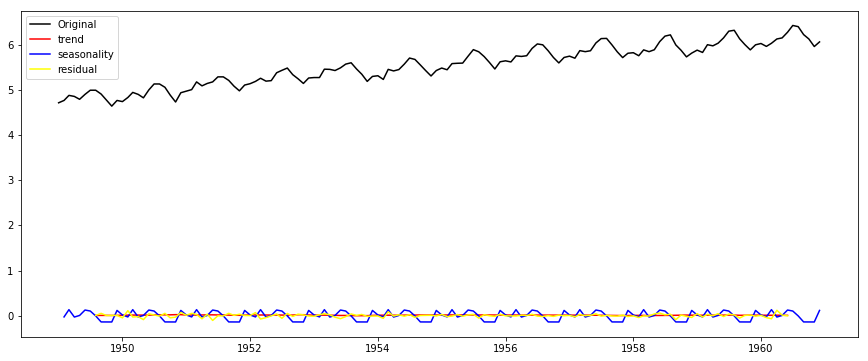

P-value for Dickey_Fuller Test: 0.07112054815086118


In [74]:
ts_log_diff=data_df['log_diff']
ts_log_diff.index=data_df['Month']
decom=seasonal_decompose(ts_log_diff,model='additive')

trend=decom.trend
seasonal=decom.seasonal
residual=decom.resid

plt.plot(ts_log_time,label='Original',color='black')
#plt.legend(loc='best')
plt.plot(trend,label='trend',color='red')
#plt.legend(loc='best')
plt.plot(seasonal,label='seasonality',color='blue')
#plt.legend(loc='best')
plt.plot(residual,label='residual',color='yellow')
plt.legend(loc='best')
plt.show()

DF_test=adfuller(data_df['log_diff'],regression='c')
print('P-value for Dickey_Fuller Test:',DF_test[1])

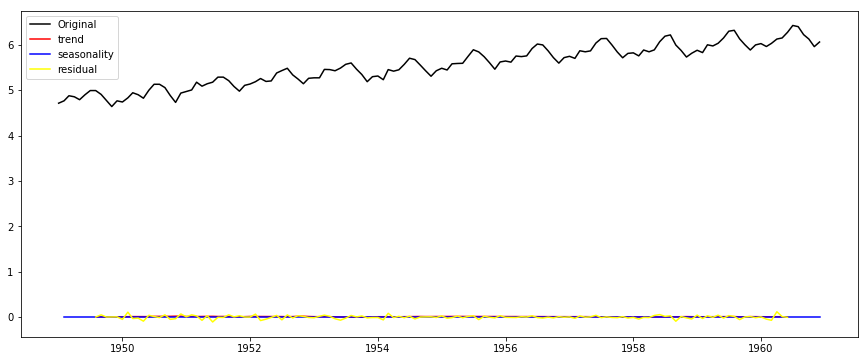

P-value for Dickey_Fuller Test: 7.518313943982134e-09


In [75]:
ts_log_diff_season=ts_log_diff-seasonal

decom=seasonal_decompose(ts_log_diff_season,model='additive')

trend2=decom.trend
seasonal2=decom.seasonal
residual2=decom.resid

plt.plot(ts_log_time,label='Original',color='black')
#plt.legend(loc='best')
plt.plot(trend2,label='trend',color='red')
#plt.legend(loc='best')
plt.plot(seasonal2,label='seasonality',color='blue')
#plt.legend(loc='best')
plt.plot(residual2,label='residual',color='yellow')
plt.legend(loc='best')
plt.show()

DF_test=adfuller(ts_log_diff_season,regression='c')
print('P-value for Dickey_Fuller Test:',DF_test[1])

## Predictive Modeling on TS
**ARIMA model**
<br> Auto-Regressive Integrated Moving Averages
1. Number of AR (Auto-Regressive) terms (p): 
<br>AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
2. Number of MA (Moving Average) terms (q):  
<br>MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
3. Number of Differences (d):  
<br>These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

**How to decide P and Q?**
1. Autocorrelation Function (ACF):
<br>It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
2. Partial Autocorrelation Function (PACF):
<br> This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

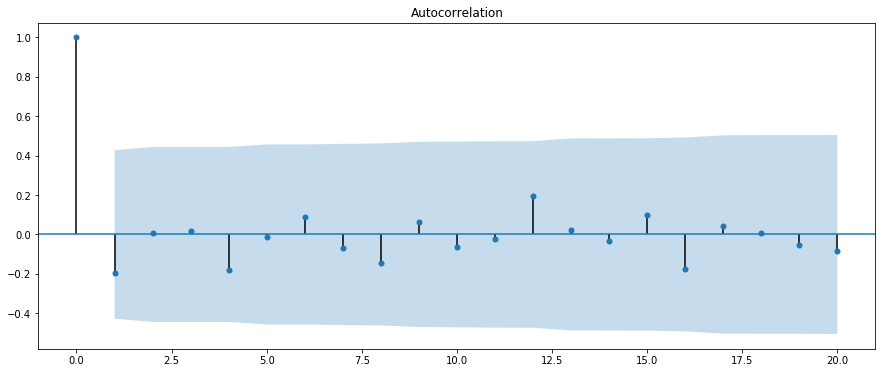

In [80]:
lag_acf=acf(ts_log_diff_season,nlags=20)
plot_acf(lag_acf)
plt.show()

Intepretation: q=0 'acoss the confidence interval for the first time'

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


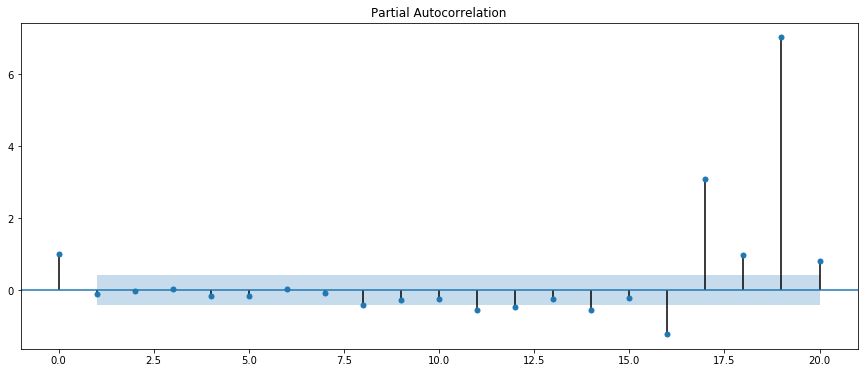

In [79]:
lag_pacf=pacf(ts_log_diff_season,nlags=20)
plot_pacf(lag_pacf)
plt.show() 

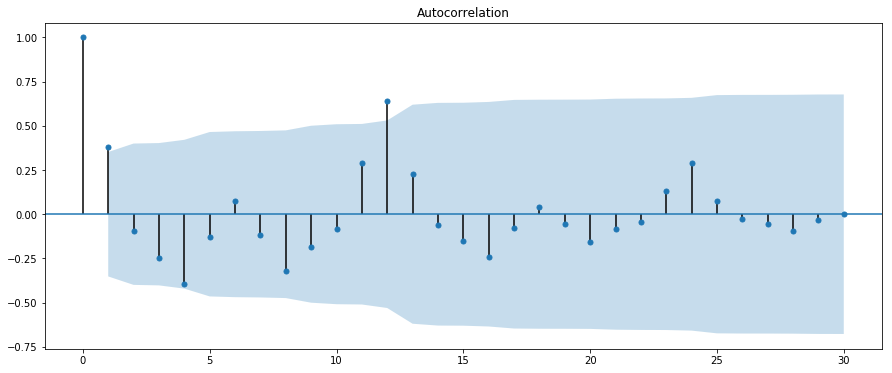

In [90]:
lag_acf=acf(seasonal,nlags=30)
plot_acf(lag_acf)
plt.show()

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


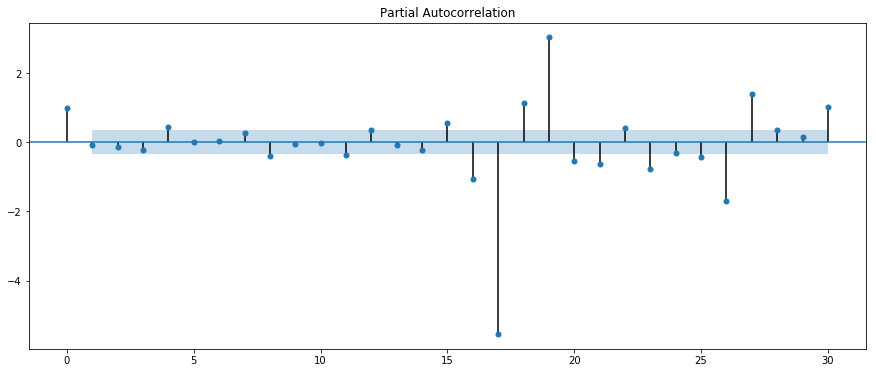

In [91]:
lag_pacf=pacf(seasonal,nlags=30)
plot_pacf(lag_pacf)
plt.show() 

Intepretation: p=8 'acoss the confidence interval for the first time'

**ARIMA Model**

In [82]:
# split train and test dateset
train=ts_log_time[:"1958-01-01"]
test=ts_log_time["1958-01-01":]
print(len(train),':',len(test))

109 : 36


In [113]:
for p in range(0,11):
    for P in range(0,4):
        print('p=',p)
        print('P=',P)
        model=SARIMAX(train,trend='n',order=(p,1,0),seasonal=(P,1,1,12))
        results=model.fit()
        print(results.summary())

p= 0
P= 0
                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  109
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  91.240
Date:                Thu, 03 Jan 2019   AIC                           -180.480
Time:                        21:35:01   BIC                           -177.798
Sample:                    01-01-1949   HQIC                          -179.393
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0108      0.002      5.069      0.000       0.007       0.015
Ljung-Box (Q):                      320.40   Jarque-Bera (JB):                 5.26
Prob(Q):                             

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa

                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  109
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  91.240
Date:                Thu, 03 Jan 2019   AIC                           -180.480
Time:                        21:35:02   BIC                           -177.798
Sample:                    01-01-1949   HQIC                          -179.393
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0108      0.002      5.069      0.000       0.007       0.015
Ljung-Box (Q):                      320.40   Jarque-Bera (JB):                 5.26
Prob(Q):                              0.00   Pr

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  109
Model:               SARIMAX(1, 1, 0)   Log Likelihood                  92.999
Date:                Thu, 03 Jan 2019   AIC                           -181.998
Time:                        21:35:02   BIC                           -176.634
Sample:                    01-01-1949   HQIC                          -179.823
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1784      0.104      1.712      0.087      -0.026       0.383
sigma2         0.0105      0.002      5.254      0.000       0.007       0.014
Ljung-Box (Q):                      284.76   Jarque-

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  109
Model:               SARIMAX(2, 1, 0)   Log Likelihood                  94.818
Date:                Thu, 03 Jan 2019   AIC                           -183.636
Time:                        21:35:02   BIC                           -175.590
Sample:                    01-01-1949   HQIC                          -180.374
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2104      0.114      1.848      0.065      -0.013       0.434
ar.L2         -0.1821      0.126     -1.442      0.149      -0.430       0.065
sigma2         0.0101      0.002      5.313      0.0

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  109
Model:               SARIMAX(2, 1, 0)   Log Likelihood                  94.818
Date:                Thu, 03 Jan 2019   AIC                           -183.636
Time:                        21:35:02   BIC                           -175.590
Sample:                    01-01-1949   HQIC                          -180.374
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2104      0.114      1.848      0.065      -0.013       0.434
ar.L2         -0.1821      0.126     -1.442      0.149      -0.430       0.065
sigma2         0.0101      0.002      5.313      0.0

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  109
Model:               SARIMAX(3, 1, 0)   Log Likelihood                  94.992
Date:                Thu, 03 Jan 2019   AIC                           -181.985
Time:                        21:35:03   BIC                           -171.256
Sample:                    01-01-1949   HQIC                          -177.635
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1998      0.116      1.729      0.084      -0.027       0.426
ar.L2         -0.1693      0.137     -1.236      0.217      -0.438       0.099
ar.L3         -0.0573      0.097     -0.592      0.5

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)



p= 4
P= 0
                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  109
Model:               SARIMAX(4, 1, 0)   Log Likelihood                 100.806
Date:                Thu, 03 Jan 2019   AIC                           -191.612
Time:                        21:35:03   BIC                           -178.201
Sample:                    01-01-1949   HQIC                          -186.175
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1804      0.100      1.803      0.071      -0.016       0.376
ar.L2         -0.2196      0.118     -1.855      0.064      -0.452       0.012
ar.L3          0.0065      0.093      0.0

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)



p= 4
P= 1
                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  109
Model:               SARIMAX(4, 1, 0)   Log Likelihood                 100.806
Date:                Thu, 03 Jan 2019   AIC                           -191.612
Time:                        21:35:03   BIC                           -178.201
Sample:                    01-01-1949   HQIC                          -186.175
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1804      0.100      1.803      0.071      -0.016       0.376
ar.L2         -0.2196      0.118     -1.855      0.064      -0.452       0.012
ar.L3          0.0065      0.093      0.0

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  109
Model:               SARIMAX(4, 1, 0)   Log Likelihood                 100.806
Date:                Thu, 03 Jan 2019   AIC                           -191.612
Time:                        21:35:03   BIC                           -178.201
Sample:                    01-01-1949   HQIC                          -186.175
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1804      0.100      1.803      0.071      -0.016       0.376
ar.L2         -0.2196      0.118     -1.855      0.064      -0.452       0.012
ar.L3          0.0065      0.093      0.070      0.9

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  109
Model:               SARIMAX(5, 1, 0)   Log Likelihood                 100.846
Date:                Thu, 03 Jan 2019   AIC                           -189.693
Time:                        21:35:04   BIC                           -173.600
Sample:                    01-01-1949   HQIC                          -183.167
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1899      0.112      1.695      0.090      -0.030       0.409
ar.L2         -0.2198      0.123     -1.782      0.075      -0.462       0.022
ar.L3          0.0128      0.098      0.130      0.8

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  109
Model:               SARIMAX(5, 1, 0)   Log Likelihood                 100.846
Date:                Thu, 03 Jan 2019   AIC                           -189.693
Time:                        21:35:04   BIC                           -173.600
Sample:                    01-01-1949   HQIC                          -183.167
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1899      0.112      1.695      0.090      -0.030       0.409
ar.L2         -0.2198      0.123     -1.782      0.075      -0.462       0.022
ar.L3          0.0128      0.098      0.130      0.8

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  109
Model:               SARIMAX(5, 1, 0)   Log Likelihood                 100.846
Date:                Thu, 03 Jan 2019   AIC                           -189.693
Time:                        21:35:04   BIC                           -173.600
Sample:                    01-01-1949   HQIC                          -183.167
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1899      0.112      1.695      0.090      -0.030       0.409
ar.L2         -0.2198      0.123     -1.782      0.075      -0.462       0.022
ar.L3          0.0128      0.098      0.130      0.8

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  109
Model:               SARIMAX(5, 1, 0)   Log Likelihood                 100.846
Date:                Thu, 03 Jan 2019   AIC                           -189.693
Time:                        21:35:04   BIC                           -173.600
Sample:                    01-01-1949   HQIC                          -183.167
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1899      0.112      1.695      0.090      -0.030       0.409
ar.L2         -0.2198      0.123     -1.782      0.075      -0.462       0.022
ar.L3          0.0128      0.098      0.130      0.8

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  109
Model:               SARIMAX(6, 1, 0)   Log Likelihood                 100.849
Date:                Thu, 03 Jan 2019   AIC                           -187.697
Time:                        21:35:05   BIC                           -168.922
Sample:                    01-01-1949   HQIC                          -180.084
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1897      0.114      1.667      0.095      -0.033       0.413
ar.L2         -0.2175      0.128     -1.694      0.090      -0.469       0.034
ar.L3          0.0126      0.099      0.128      0.8

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  109
Model:               SARIMAX(6, 1, 0)   Log Likelihood                 100.849
Date:                Thu, 03 Jan 2019   AIC                           -187.697
Time:                        21:35:05   BIC                           -168.922
Sample:                    01-01-1949   HQIC                          -180.084
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1897      0.114      1.667      0.095      -0.033       0.413
ar.L2         -0.2175      0.128     -1.694      0.090      -0.469       0.034
ar.L3          0.0126      0.099      0.128      0.8

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  109
Model:               SARIMAX(6, 1, 0)   Log Likelihood                 100.849
Date:                Thu, 03 Jan 2019   AIC                           -187.697
Time:                        21:35:05   BIC                           -168.922
Sample:                    01-01-1949   HQIC                          -180.084
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1897      0.114      1.667      0.095      -0.033       0.413
ar.L2         -0.2175      0.128     -1.694      0.090      -0.469       0.034
ar.L3          0.0126      0.099      0.128      0.8

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  109
Model:               SARIMAX(6, 1, 0)   Log Likelihood                 100.849
Date:                Thu, 03 Jan 2019   AIC                           -187.697
Time:                        21:35:06   BIC                           -168.922
Sample:                    01-01-1949   HQIC                          -180.084
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1897      0.114      1.667      0.095      -0.033       0.413
ar.L2         -0.2175      0.128     -1.694      0.090      -0.469       0.034
ar.L3          0.0126      0.099      0.128      0.8

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  109
Model:               SARIMAX(7, 1, 0)   Log Likelihood                 103.354
Date:                Thu, 03 Jan 2019   AIC                           -190.708
Time:                        21:35:06   BIC                           -169.251
Sample:                    01-01-1949   HQIC                          -182.008
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1914      0.118      1.619      0.105      -0.040       0.423
ar.L2         -0.2130      0.129     -1.648      0.099      -0.466       0.040
ar.L3         -0.0628      0.118     -0.532      0.5

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  109
Model:               SARIMAX(7, 1, 0)   Log Likelihood                 103.354
Date:                Thu, 03 Jan 2019   AIC                           -190.708
Time:                        21:35:06   BIC                           -169.251
Sample:                    01-01-1949   HQIC                          -182.008
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1914      0.118      1.619      0.105      -0.040       0.423
ar.L2         -0.2130      0.129     -1.648      0.099      -0.466       0.040
ar.L3         -0.0628      0.118     -0.532      0.5

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  109
Model:               SARIMAX(7, 1, 0)   Log Likelihood                 103.354
Date:                Thu, 03 Jan 2019   AIC                           -190.708
Time:                        21:35:07   BIC                           -169.251
Sample:                    01-01-1949   HQIC                          -182.008
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1914      0.118      1.619      0.105      -0.040       0.423
ar.L2         -0.2130      0.129     -1.648      0.099      -0.466       0.040
ar.L3         -0.0628      0.118     -0.532      0.5

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  109
Model:               SARIMAX(7, 1, 0)   Log Likelihood                 103.354
Date:                Thu, 03 Jan 2019   AIC                           -190.708
Time:                        21:35:07   BIC                           -169.251
Sample:                    01-01-1949   HQIC                          -182.008
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1914      0.118      1.619      0.105      -0.040       0.423
ar.L2         -0.2130      0.129     -1.648      0.099      -0.466       0.040
ar.L3         -0.0628      0.118     -0.532      0.5

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  109
Model:               SARIMAX(8, 1, 0)   Log Likelihood                 114.962
Date:                Thu, 03 Jan 2019   AIC                           -211.925
Time:                        21:35:08   BIC                           -187.786
Sample:                    01-01-1949   HQIC                          -202.137
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0970      0.107      0.904      0.366      -0.113       0.307
ar.L2         -0.1900      0.112     -1.697      0.090      -0.409       0.029
ar.L3         -0.0686      0.105     -0.652      0.5

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  109
Model:               SARIMAX(8, 1, 0)   Log Likelihood                 114.962
Date:                Thu, 03 Jan 2019   AIC                           -211.925
Time:                        21:35:08   BIC                           -187.786
Sample:                    01-01-1949   HQIC                          -202.137
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0970      0.107      0.904      0.366      -0.113       0.307
ar.L2         -0.1900      0.112     -1.697      0.090      -0.409       0.029
ar.L3         -0.0686      0.105     -0.652      0.5

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  109
Model:               SARIMAX(8, 1, 0)   Log Likelihood                 114.962
Date:                Thu, 03 Jan 2019   AIC                           -211.925
Time:                        21:35:09   BIC                           -187.786
Sample:                    01-01-1949   HQIC                          -202.137
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0970      0.107      0.904      0.366      -0.113       0.307
ar.L2         -0.1900      0.112     -1.697      0.090      -0.409       0.029
ar.L3         -0.0686      0.105     -0.652      0.5

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  109
Model:               SARIMAX(8, 1, 0)   Log Likelihood                 114.962
Date:                Thu, 03 Jan 2019   AIC                           -211.925
Time:                        21:35:09   BIC                           -187.786
Sample:                    01-01-1949   HQIC                          -202.137
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0970      0.107      0.904      0.366      -0.113       0.307
ar.L2         -0.1900      0.112     -1.697      0.090      -0.409       0.029
ar.L3         -0.0686      0.105     -0.652      0.5

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  109
Model:               SARIMAX(9, 1, 0)   Log Likelihood                 115.498
Date:                Thu, 03 Jan 2019   AIC                           -210.996
Time:                        21:35:10   BIC                           -184.175
Sample:                    01-01-1949   HQIC                          -200.121
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0500      0.126      0.397      0.692      -0.197       0.297
ar.L2         -0.2014      0.126     -1.599      0.110      -0.448       0.045
ar.L3         -0.0740      0.115     -0.645      0.5

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  109
Model:               SARIMAX(9, 1, 0)   Log Likelihood                 115.498
Date:                Thu, 03 Jan 2019   AIC                           -210.996
Time:                        21:35:10   BIC                           -184.175
Sample:                    01-01-1949   HQIC                          -200.121
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0500      0.126      0.397      0.692      -0.197       0.297
ar.L2         -0.2014      0.126     -1.599      0.110      -0.448       0.045
ar.L3         -0.0740      0.115     -0.645      0.5

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  109
Model:               SARIMAX(9, 1, 0)   Log Likelihood                 115.498
Date:                Thu, 03 Jan 2019   AIC                           -210.996
Time:                        21:35:11   BIC                           -184.175
Sample:                    01-01-1949   HQIC                          -200.121
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0500      0.126      0.397      0.692      -0.197       0.297
ar.L2         -0.2014      0.126     -1.599      0.110      -0.448       0.045
ar.L3         -0.0740      0.115     -0.645      0.5

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  109
Model:              SARIMAX(10, 1, 0)   Log Likelihood                 122.900
Date:                Thu, 03 Jan 2019   AIC                           -223.800
Time:                        21:35:12   BIC                           -194.296
Sample:                    01-01-1949   HQIC                          -211.837
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0124      0.114      0.109      0.913      -0.212       0.237
ar.L2         -0.3644      0.117     -3.120      0.002      -0.593      -0.135
ar.L3         -0.1212      0.112     -1.085      0.2

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  109
Model:              SARIMAX(10, 1, 0)   Log Likelihood                 122.900
Date:                Thu, 03 Jan 2019   AIC                           -223.800
Time:                        21:35:13   BIC                           -194.296
Sample:                    01-01-1949   HQIC                          -211.837
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0124      0.114      0.109      0.913      -0.212       0.237
ar.L2         -0.3644      0.117     -3.120      0.002      -0.593      -0.135
ar.L3         -0.1212      0.112     -1.085      0.2

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  109
Model:              SARIMAX(10, 1, 0)   Log Likelihood                 122.900
Date:                Thu, 03 Jan 2019   AIC                           -223.800
Time:                        21:35:14   BIC                           -194.296
Sample:                    01-01-1949   HQIC                          -211.837
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0124      0.114      0.109      0.913      -0.212       0.237
ar.L2         -0.3644      0.117     -3.120      0.002      -0.593      -0.135
ar.L3         -0.1212      0.112     -1.085      0.2

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  109
Model:              SARIMAX(10, 1, 0)   Log Likelihood                 122.900
Date:                Thu, 03 Jan 2019   AIC                           -223.800
Time:                        21:35:15   BIC                           -194.296
Sample:                    01-01-1949   HQIC                          -211.837
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0124      0.114      0.109      0.913      -0.212       0.237
ar.L2         -0.3644      0.117     -3.120      0.002      -0.593      -0.135
ar.L3         -0.1212      0.112     -1.085      0.2

c:\users\wuyuhang\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                           Statespace Model Results                           
Dep. Variable:            #Passengers   No. Observations:                  144
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 120.299
Date:                Thu, 03 Jan 2019   AIC                           -236.598
Time:                        21:47:00   BIC                           -230.672
Sample:                    01-01-1949   HQIC                          -234.190
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2054      0.093      2.204      0.028       0.023       0.388
sigma2         0.0109      0.002      6.050      0.000       0.007       0.014
Ljung-Box (Q):                      394.17   Jarque-

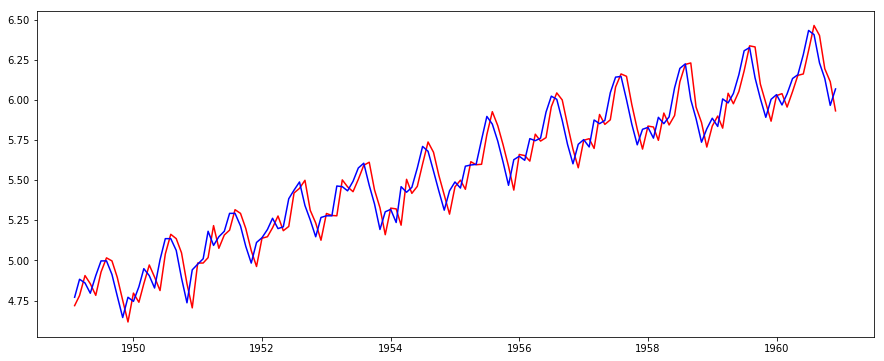

In [130]:
model=SARIMAX(ts_log_time,tend='n',order=(1,1,0),seasonal=(1,1,1,12))
results=model.fit()
print(results.summary())
pred=results.fittedvalues  
plt.plot(pred['1949-02-01':],color='red')
plt.plot(ts_log_time['1949-02-01':],color='blue')
plt.show()
